# the following model creation code should be run on kaggel

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Sequential
import numpy as np
from keras.layers import Dense, Flatten ,Dropout,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from PIL import Image
import os
import shutil
import random

# bring the dataset of flowers-299 in the add data section



In [ ]:
original_folder = "/kaggle/input/flowers-299-augmented/flower299_aug"
train_folder = "/kaggle/working/Train"
test_folder = "/kaggle/working/Test"

test_percentage = 0.2

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
class_folders = [folder for folder in os.listdir(original_folder) if os.path.isdir(os.path.join(original_folder, folder))]
class_folders.sort()
print(class_folders)

['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', 'Baby’sBreath', 'Bachelor’sButton', 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', 'Columbine', 'Coneflower', 'CoralBells', 'CoralVine', 'Coreopsis', 'Cornflower', 'Corydalis', 'Cosmos', 'Cotonea

# above the list of all 299 flower classes

### divding in test and train

In [ ]:
for class_folder in class_folders:

    class_folder_path = os.path.join(original_folder, class_folder)
    train_class_folder = os.path.join(train_folder, class_folder)
    test_class_folder = os.path.join(test_folder, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

    # Get the list of images and get the amount of images to be places in test
    image_files = [file for file in os.listdir(class_folder_path) if file.endswith(".jpg") or file.endswith(".png")]
    num_images = len(image_files)
    num_test_images = int(num_images * test_percentage)

    # divide in test and train
    test_images = random.sample(image_files, num_test_images)
    image_files = list(set(image_files)-set(test_images))

    # add them to their designated folder
    for image in test_images:
        src_path = os.path.join(class_folder_path, image)
        dest_path = os.path.join(test_class_folder, image)
        shutil.copy(src_path, dest_path)
    for image in image_files:
        src_path = os.path.join(class_folder_path, image)
        dest_path = os.path.join(train_class_folder, image)
        shutil.copy(src_path, dest_path)

# generates a data generator that will apply data augentation with a set num of batch size, image label, and image size using the flow_from_directory() function

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/working/Train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 128,
    image_size = (224,224)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/working/Test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 128,
    image_size = (224,224)
)



Found 421255 files belonging to 299 classes.
Found 105153 files belonging to 299 classes.


# data normalization

In [ ]:
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
print('done')

done


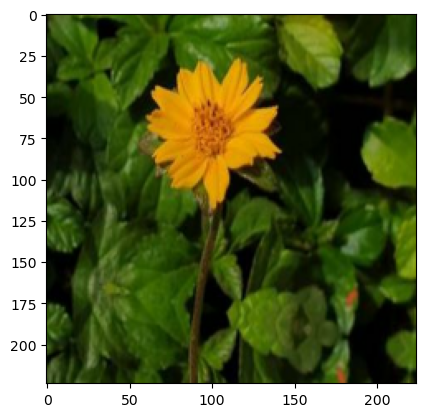

tf.Tensor(282, shape=(), dtype=int32) Wedelia


In [ ]:
for data,lable in train_ds:
    n = 1
    image = data[n]
    image = image.numpy()
    plt.imshow(image)
    plt.show()
    print(lable[n],class_folders[lable[n]])
    break


# Creating the ResNet50 model

### transfer learninng resnet 50

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [ ]:
with strategy.scope():
    base_model = ResNet50V2(weights=None, include_top=False, input_shape=(224, 224, 3),pooling='max',)
    weights_path = "/kaggle/input/groggy/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
    base_model.load_weights(weights_path)

    for index, layer in enumerate(base_model.layers):
        if index < 80:
            layer.trainable = False
        else:
            layer.trainable = True

    resnet_model = Sequential()

    resnet_model.add(base_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dropout(0.3))
    resnet_model.add(Dense(299, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 299)               612651    
                                                                 
Total params: 24,177,451
Trainable params: 22,899,755
Non-trainable params: 1,277,696
_________________________________________________________________


## create the model

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## using checkpoints to save the weights of the model when it has the lowest val_loss

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = '/kaggle/working/ModelCheckpoints/Checkpoint-Res50K_3.h5'
checkpoint = ModelCheckpoint(filepath,monitor = 'val_loss',varbose=1,save_best_only = True,mode = 'min')
print('doe')

doe


In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

### to load a previously saved checkpoint


In [ ]:
# checkpoint_file = '/kaggle/working/ModelCheckpoints/Checkpoint-Res50K_3.h5'
# resnet_model.load_weights(checkpoint_file)

 # Run your RasNet50 model

In [ ]:
history = resnet_model.fit(train_ds, epochs = 30, validation_data = validation_ds,callbacks=[early_stop])

Epoch 1/30
3292/3292 [==============================] - 2097s 627ms/step - loss: 2.8785 - accuracy: 0.3619 - val_loss: 1.8202 - val_accuracy: 0.5477
Epoch 2/30
3292/3292 [==============================] - 2110s 640ms/step - loss: 1.6372 - accuracy: 0.5895 - val_loss: 1.2834 - val_accuracy: 0.6692
Epoch 3/30
3292/3292 [==============================] - 2067s 627ms/step - loss: 1.2409 - accuracy: 0.6746 - val_loss: 1.1078 - val_accuracy: 0.7081
Epoch 4/30
3292/3292 [==============================] - 2055s 623ms/step - loss: 0.9647 - accuracy: 0.7363 - val_loss: 0.9096 - val_accuracy: 0.7553
Epoch 5/30
3292/3292 [==============================] - 2067s 627ms/step - loss: 0.7608 - accuracy: 0.7846 - val_loss: 0.7757 - val_accuracy: 0.7886
Epoch 6/30
3292/3292 [==============================] - 2074s 629ms/step - loss: 0.6080 - accuracy: 0.8214 - val_loss: 0.6936 - val_accuracy: 0.8086
Epoch 7/30
3292/3292 [==============================] - 2062s 626ms/step - loss: 0.4980 - accuracy: 0.8502

# Plot the accuracy and loss graph

In [ ]:
# plt.plot(history.history['loss'],'y',label = 'train loss')
# plt.plot(history.history['val_loss'],'r',label = 'validation loss')
# plt.legend()
# plt.show()

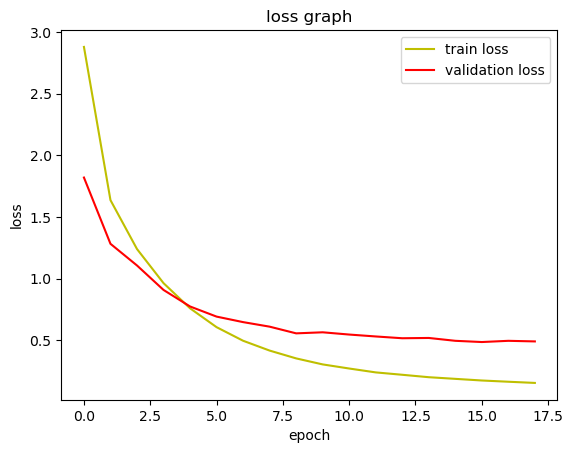

In [ ]:
plt.plot(history.history['loss'],'y',label = 'train loss')
plt.plot(history.history['val_loss'],'r',label = 'validation loss')
plt.title("loss graph")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# plt.plot(history.history['accuracy'],'y',label = 'train acc')
# plt.plot(history.history['val_accuracy'],'r',label = 'validation acc')
# plt.legend()
# plt.show()

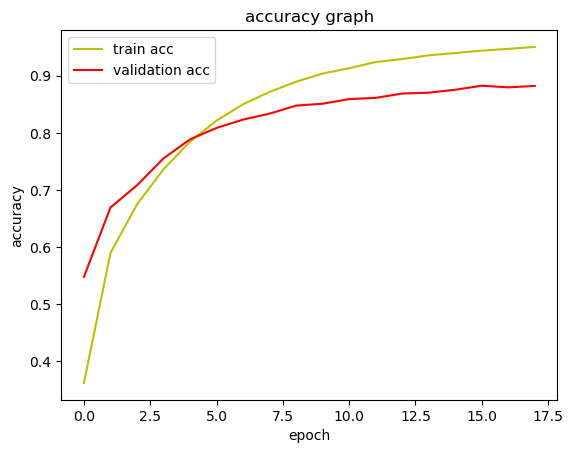

In [ ]:
plt.plot(history.history['accuracy'],'y',label = 'train acc')
plt.plot(history.history['val_accuracy'],'r',label = 'validation acc')
plt.title("accuracy graph")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# to test loss and accuracy one last time using model.evaluate()

In [ ]:
preds = resnet_model.evaluate(validation_ds)
print("Test Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

822/822 [==============================] - 280s 338ms/step - loss: 0.4870 - accuracy: 0.8831
Test Loss = 0.4870118498802185
Test Accuracy = 0.8830751180648804


In [ ]:
# import cv2
# img1 = '/content/rose_0.jpg'
# img2 = '/content/rose_1.jpg'
# img3 = '/content/rose_2.png'
# img4 = '/content/rose_3.jpg'
# img5 = '/content/rose_4.jpg'
# img6 = '/content/rose_5.jpg'
# img7 = '/content/sunflower_1.jpg'
# img8 = '/content/sunflower_2.jpg'
# img9 = '/content/sunflower_3.jpg'
# img10 = '/content/tulip_1.jpg'
# img11 = '/content/tulip_2.jpg'
# img12 = '/content/tulip_3.jpg'
# img13 = '/content/tulip_4.jpg'

# image = cv2.imread(img13)
# image = cv2.resize(image, (224, 224))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()
# image = np.expand_dims(image, axis=0)
# image = tf.cast(image/255., tf.float32)


# pred=model.predict(image)
# output_class=class_folders[np.argmax(pred)]
# print(np.argmax(pred),"The predicted class is", output_class)

### save & model from kaggle

In [ ]:
resnet_model.save('/kaggle/working/model.h5')

In [ ]:
!cd /kaggle/working/models
!ls

In [ ]:
!zip -r models.zip ./models
!ls

In [ ]:
from IPython.display import FileLink
FileLink(r'model.h5')

In [ ]:
# !rm -r /kaggle/working/file.zip